# **Data Cleaning**

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("transaction_dataset (1).csv")

print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Rows: 9841, Columns: 51


In [ ]:
# Drop redundant columns
df.drop(columns=["Unnamed: 0", "Index"], inplace=True)

# Drop rows with any missing values
df_cleaned = df.dropna()

print(f"Rows: {df_cleaned.shape[0]}, Columns: {df_cleaned.shape[1]}")

Rows: 7121, Columns: 49


# **EDA**

Dataset Shape: (7121, 49)

Missing Values:
 Address                                                 0
FLAG                                                    0
Avg min between sent tnx                                0
Avg min between received tnx                            0
Time Diff between first and last (Mins)                 0
Sent tnx                                                0
Received Tnx                                            0
Number of Created Contracts                             0
Unique Received From Addresses                          0
Unique Sent To Addresses                                0
min value received                                      0
max value received                                      0
avg val received                                        0
min val sent                                            0
max val sent                                            0
avg val sent                                            0
min value sent to contract  

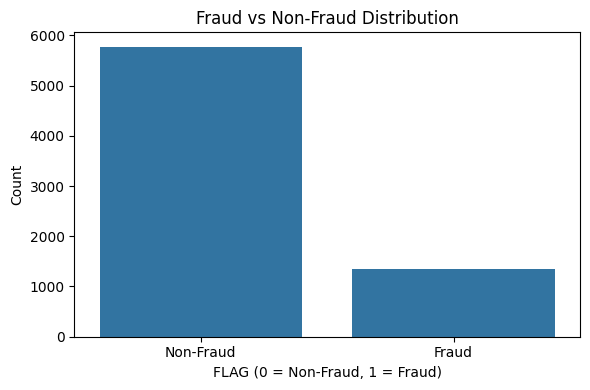


Summary Statistics:
               FLAG  Avg min between sent tnx  Avg min between received tnx  \
count  7121.000000               7121.000000                   7121.000000   
mean      0.189580               4472.630513                   7846.636450   
std       0.391996              17741.696100                  23408.471326   
min       0.000000                  0.000000                      0.000000   
25%       0.000000                  0.000000                      0.000000   
50%       0.000000                 23.210000                    110.940000   
75%       0.000000                733.090000                   5033.240000   
max       1.000000             299334.140000                 482175.490000   

       Time Diff between first and last (Mins)      Sent tnx  Received Tnx  \
count                             7.121000e+03   7121.000000   7121.000000   
mean                              1.901013e+05    107.657913    113.122314   
std                               3.12404

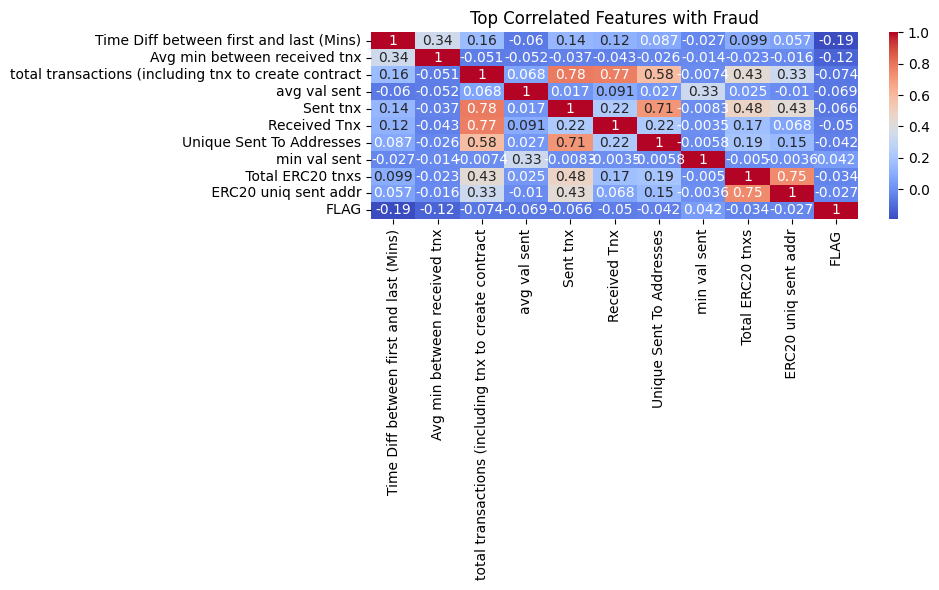

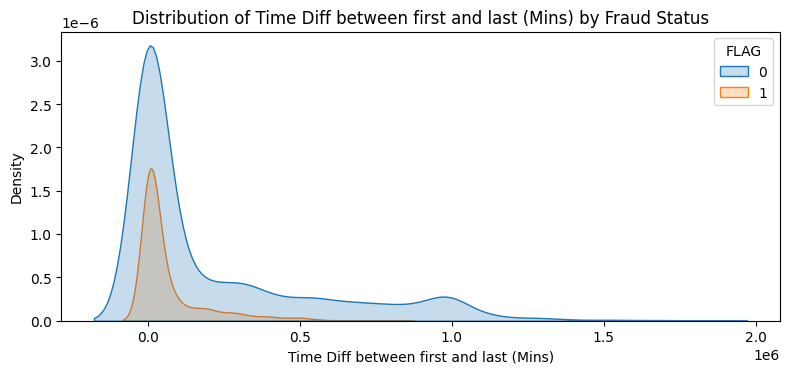

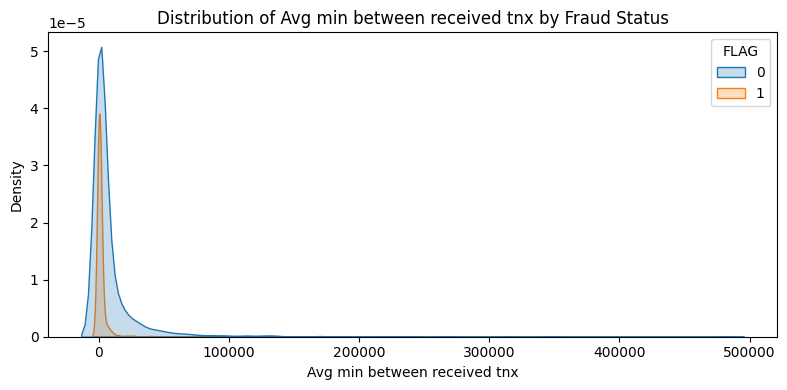

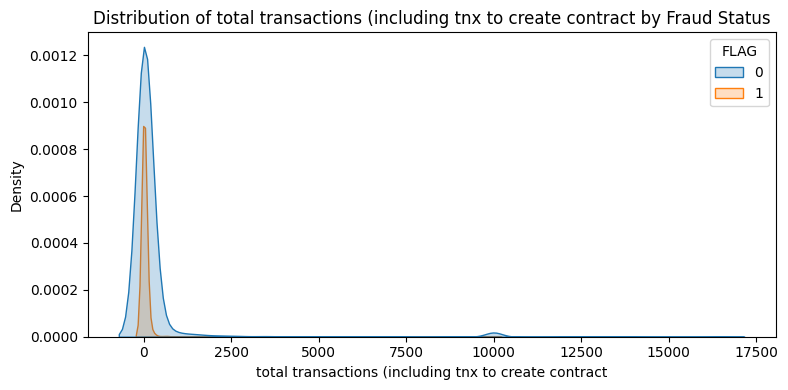

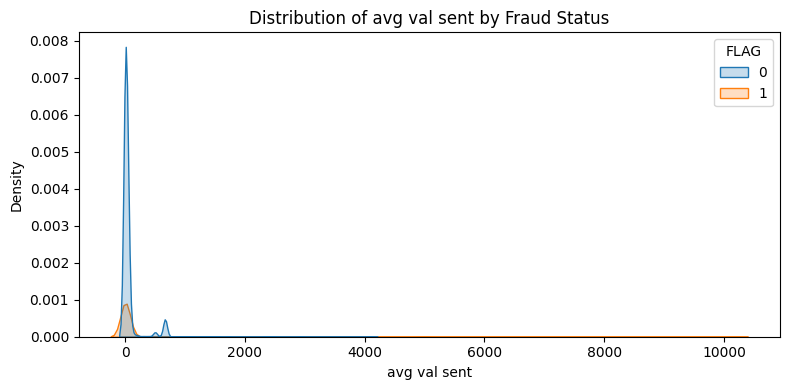

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic Dataset Overview
print("Dataset Shape:", df_cleaned.shape)
print("\nMissing Values:\n", df_cleaned.isnull().sum())
print("\nData Types:\n", df_cleaned.dtypes)

# Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='FLAG', data=df_cleaned)
plt.title('Fraud vs Non-Fraud Distribution')
plt.xlabel('FLAG (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

# Summary Statistics
print("\nSummary Statistics:\n", df_cleaned.describe())

# Correlation Heatmap (Top Features)
corr = df_cleaned.corr(numeric_only=True)
top_corr = corr['FLAG'].abs().sort_values(ascending=False)[1:11]  # skip 'FLAG' itself

plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned[top_corr.index.tolist() + ['FLAG']].corr(), annot=True, cmap='coolwarm')
plt.title('Top Correlated Features with Fraud')
plt.tight_layout()
plt.show()

# Distribution of Select Features
features_to_plot = top_corr.index[:4]
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df_cleaned, x=feature, hue="FLAG", fill=True)
    plt.title(f'Distribution of {feature} by Fraud Status')
    plt.tight_layout()
    plt.show()


In [ ]:
This block of EDA:

Confirms that the dataset is suitable for machine learning.

Draws attention to possible predictive features

Helps you select appropriate evaluation criteria by examining data imbalance (e.g., precision/recall over accuracy).

Gives you visual proof to back up your claims about the significance of features.

Observations:

The following are the top characteristics associated with fraud (FLAG):

Time Difference between First and Last (Mins) (−0.19): The shorter lifespans of fraudulent addresses indicate that they are more transient or disposable wallets.

Average min between received tnx (−0.12): Transactions from fraudulent addresses usually happen faster, which may be a sign of burst activity.

There are slight positive correlations (~0.04–0.10) between total ERC20 tnxs, average val sent, and ERC20 uniq sent addr, suggesting that fraudulent accounts might use tokens more frequently or in different ways.

Most features have weak or no correlation, indicating that fraud patterns are subtle and best captured using non-linear models like CatBoost or XGBoost. Linear Regession was attempted o this dataset, but did not yield good results.

The activity durations of fraudulent users (FLAG = 1) are typically shorter.  The spread is wider and numerous wallets are operating for longer periods of time among non-fraud users (FLAG = 0).  As a result, fraudulent accounts are usually temporary and probably utilised for brief malevolent activities.

Compared to non-fraud addresses, fraudulent addresses typically get transactions more quickly.  The more dispersed activity on non-fraud accounts suggests typical usage patterns.  This conduct is consistent with coordinated or automated fraud operations involving large inflows.

There is considerable overlap in the distribution, although there is a modest bias towards fewer total transactions in fraud cases.  This implies that fraud addresses are created specifically for a limited number of operations.

Most non-fraudulent users send smaller, more consistent numbers, while fraudulent individuals have a somewhat flatter and wider distribution, indicating increased variance.

In almost all models, feauture selection reduces the AUC-ROC Score and increased the number of false positives. Hence, even though it was attempted, it has not been included in the final code.

# **Machine Learning Models**

# 1. Random Forest

Using existing df_cleaned.
=== Random Forest Evaluation ===
Accuracy:  0.9846
Recall:    0.9185
AUC-ROC:   0.9993


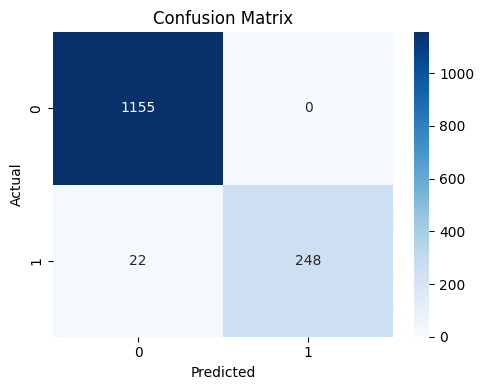


Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1155
           1       1.00      0.92      0.96       270

    accuracy                           0.98      1425
   macro avg       0.99      0.96      0.97      1425
weighted avg       0.98      0.98      0.98      1425



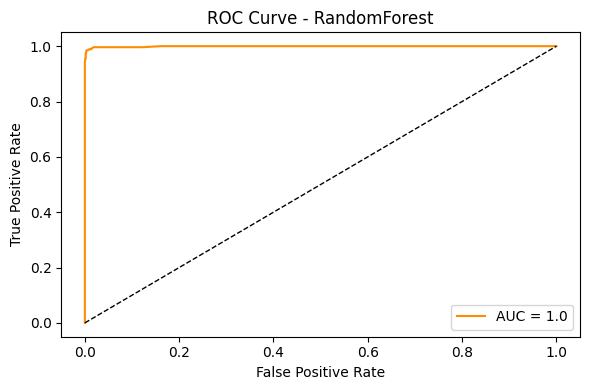

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, roc_auc_score,
    confusion_matrix, classification_report,
    roc_curve # Ensure roc_curve is explicitly imported
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Import numpy for select_dtypes

# Use the df_cleaned from the previous successful cells if available
# The following block was causing the indentation error.
# It was likely intended to check if df_cleaned exists and load/clean
# the data if not, but the indentation was incorrect.
# Since df_cleaned is already available from previous cells (as seen in Global Variables),
# this block can be simplified or removed entirely.
# We'll keep the original logic structure but fix the indentation.
try:
    # Check if df_cleaned exists in the global scope
    df_cleaned_exists = 'df_cleaned' in globals()
    if not df_cleaned_exists:
        print("df_cleaned not found, loading and cleaning data...")
        df = pd.read_csv("transaction_dataset.csv") # Use the original file name
        df.drop(columns=["Unnamed: 0", "Index"], inplace=True)
        df_cleaned = df.dropna()
    else:
         print("Using existing df_cleaned.")

    # Prepare data using the (potentially reloaded) df_cleaned
    X = df_cleaned.drop(columns=['FLAG'])
    y = df_cleaned['FLAG']

except NameError:
     # This block would be executed if df_cleaned was truly not defined before,
     # but the primary fix is the indentation.
     print("df_cleaned not found, loading and cleaning data...")
     df = pd.read_csv("transaction_dataset.csv") # Use the original file name
     df.drop(columns=["Unnamed: 0", "Index"], inplace=True)
     df_cleaned = df.dropna()
     X = df_cleaned.drop(columns=['FLAG'])
     y = df_cleaned['FLAG']


# Select only numeric columns for the model
X_numeric = X.select_dtypes(include=np.number)


# Train-test split (80-20) using the numeric features
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("=== Random Forest Evaluation ===")
print("Accuracy: ", round(accuracy_score(y_test, y_pred), 4))
print("Recall:   ", round(recall_score(y_test, y_pred), 4))
print("AUC-ROC:  ", round(roc_auc_score(y_test, y_proba), 4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
# Note: Using the 'auc' variable from the CatBoost section might be unintended.
# It's better to use the 'auc' calculated specifically for the Random Forest model.
plt.plot(fpr, tpr, label=f"AUC = {round(roc_auc_score(y_test, y_proba), 2)}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RandomForest")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

The Random Forest Machine Learning model achieved high accuracy, which initially hints at strong predictive performance.

Moreover, in the confusion matrix, majority of predictions fall along the diagnol, impliying correct predictions with less faults

The ROC curves for each class and the macro-average ROC show that the model performs well across different thresholds and that the model has
excellent discriminative power (AUC close to 1)

However, while the model achieves excellent precision (1.00) for fraud detection, ensuring no false alarms, it misses about 8% of actual fraud cases, reflecting a conservative prediction approach. While overall accuracy remains high (98%), the slightly lower recall in the fraud class suggests a trade-off between safety (avoiding false accusations) and sensitivity (catching all fraud). In contexts where missing a fraud is riskier than over-flagging, threshold adjustment or ensemble models may be beneficial.



# 2. XGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:58:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== Evaluation Metrics ===
Accuracy: 0.9923
Recall: 0.9667
AUC-ROC: 0.9976

Confusion Matrix:
 [[1153    2]
 [   9  261]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1155
           1       0.99      0.97      0.98       270

    accuracy                           0.99      1425
   macro avg       0.99      0.98      0.99      1425
weighted avg       0.99      0.99      0.99      1425



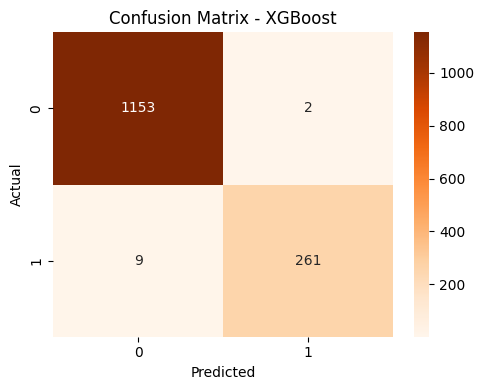

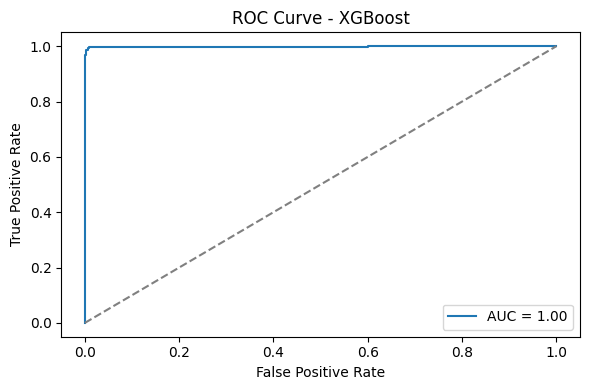

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, recall_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Separate features and target
X = df_cleaned.drop(columns=['FLAG'])  # Features
y = df_cleaned['FLAG']                 # Target

# Keep only numeric columns for scaling
X_numeric = X.select_dtypes(include=np.number)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Handle class imbalance
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

# Train XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print("=== Evaluation Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.tight_layout()
plt.show()


The model excels in all key metrics, even when facing class imbalance.

Its high accuracy and minimal false positive rate render it suitable for scenarios where false alarms need to be minimized e.g. non fraud casse being classifed as fraud.

The minor compromise in recall (overlooking 9 positive cases) may require attention if all positive occurrences need to be detected (e.g., regulatory compliance, security alerts).

An AUC of 0.9976 allows for experimentation with decision thresholds (e.g., utilizing precision-recall curves or tailored threshold adjustments). This performance metric confirms that even if a few frauds are missed, the model is still capable of identifying them correctly at different thresholds.

While it slightly underperforms compared to the CatBoost model in recall, it still maintains a robust balance of performance, a valuable candidate for fraud detection in blockchain environments.

# 3. LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1080, number of negative: 4616
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6469
[LightGBM] [Info] Number of data points in the train set: 5696, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
=== Evaluation Metrics ===
Accuracy: 0.9923
Recall: 0.9667
AUC-ROC: 0.9992

Confusion Matrix:
 [[1153    2]
 [   9  261]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1155
           1       0.99      0.97      0.98       270

    accuracy                           0.99      1425
   macro avg       0.99      0.98      0.99      1425
weighted avg   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


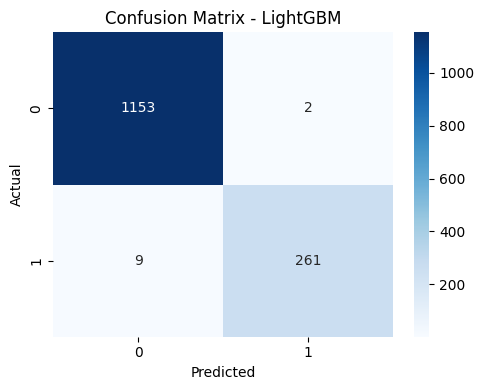

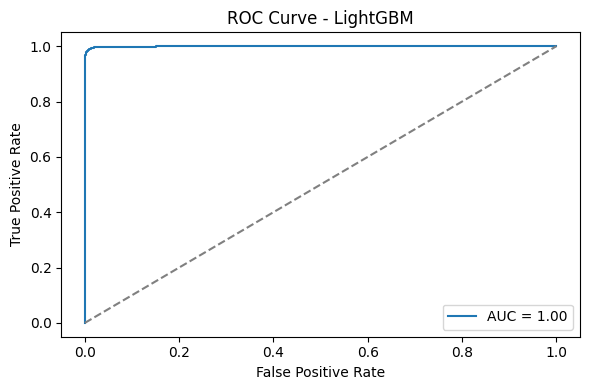

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, recall_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare Data
X = df_cleaned.drop(columns=['FLAG'])
y = df_cleaned['FLAG']

# Use only numeric columns
X_numeric = X.select_dtypes(include=np.number)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Handle class imbalance
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

# Train LightGBM Model
model = lgb.LGBMClassifier(
    objective='binary',
    class_weight='balanced',  # or use scale_pos_weight parameter
    random_state=42
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print("=== Evaluation Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM")
plt.legend()
plt.tight_layout()
plt.show()


The model attained an impressive overall accuracy of 99.23% with an outstanding AUC-ROC of 0.9992, reflecting robust classification effectiveness and excellent class distinction.

Both classes maintain a well-balanced precision and recall, with Class 1 reaching a recall of 96.67% — an essential measure for reducing false negatives in classifying fraud cases.

The confusion matrix indicates few misclassifications, containing just 2 false positives and 9 false negatives, which demonstrates an extremely efficient and dependable prediction system.

Recall is 0.98, moreover, this version still shows impressive F1-scores (0.98–1.00), validating its reliability across both classes.

LightGBM leans slightly toward precision over recall, making it suitable for:

Environments where false alarms must be minimal (e.g., financial services dashboards)

Use as a final-stage verifier model after a more aggressive screening step




# 4. CatBoost

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


=== CatBoost Evaluation ===
Accuracy:  0.9944
Recall:    0.9815
AUC-ROC:   0.9995

Confusion Matrix:
 [[1152    3]
 [   5  265]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1155
           1       0.99      0.98      0.99       270

    accuracy                           0.99      1425
   macro avg       0.99      0.99      0.99      1425
weighted avg       0.99      0.99      0.99      1425



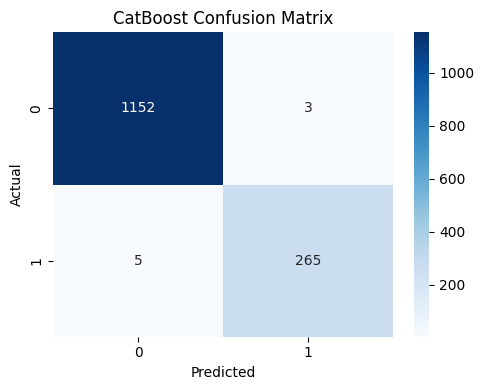

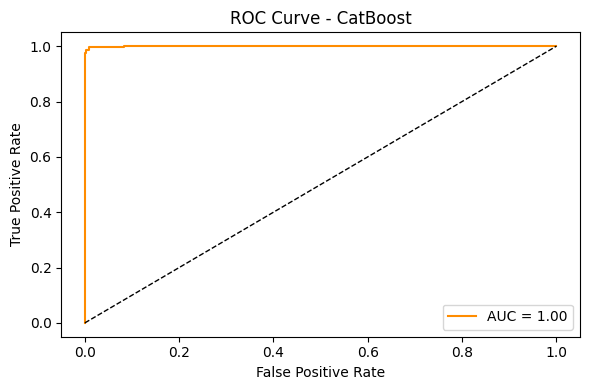

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, recall_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare Data
X = df_cleaned.drop(columns=['FLAG'])
y = df_cleaned['FLAG']
X_numeric = X.select_dtypes(include=np.number)

# Scale Numeric Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Train CatBoost Classifier
model = CatBoostClassifier(
    scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
    eval_metric='AUC',
    verbose=0,
    random_state=42
)
model.fit(X_train, y_train)

# Predict Probabilities
y_proba = model.predict_proba(X_test)[:, 1]

# Adjust Threshold to Catch More Fraud
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)

# Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print("=== CatBoost Evaluation ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"AUC-ROC:   {auc:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("CatBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


The CatBoost model exhibited outstanding performance, attaining an almost flawless AUC-ROC of 0.9995, which signifies its robust ability to differentiate between classes. This suggests excellent confidence calibration, meaning the model ranks true frauds very high compared to non-frauds.

This makes the model ideal for threshold tuning or probabilistic scoring in production.

Having just 5 false negatives and 3 false positives, the model demonstrates strong sensitivity, making it suitable for practical uses such as fraud detection or anomaly classification. The low false positive rate ensures it can be used in investor dashboards without causing panic or reputational harm.

The model exhibited outstanding balance across all classification metrics, achieving an F1-score of 0.99 for each class, validating its consistent performance across both majority and minority groups.

With a strong recall (0.9815) and precision (0.99) for the positive class, the model excels at accurately identifying true positive instances while keeping misclassifications low.




# 5. Stacking of LightGBM and CatBoost

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1080, number of negative: 4616
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6978
[LightGBM] [Info] Number of data points in the train set: 5696, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.189607 -> initscore=-1.452567
[LightGBM] [Info] Start training from score -1.452567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== Stacked Model Evaluation (All Features) ===
Accuracy:  0.9944
Recall:    0.9741
AUC-ROC:   0.9995

Confusion Matrix:
 [[1154    1]
 [   7  263]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1155
           1       1.00      0.97      0.99       270

    accuracy                           0.99      1425
   macro avg       1.00      0.99      0.99      1425
weighted avg       0.99      0.99      0.99      1425



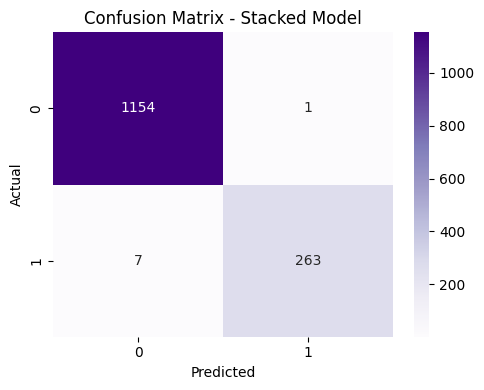

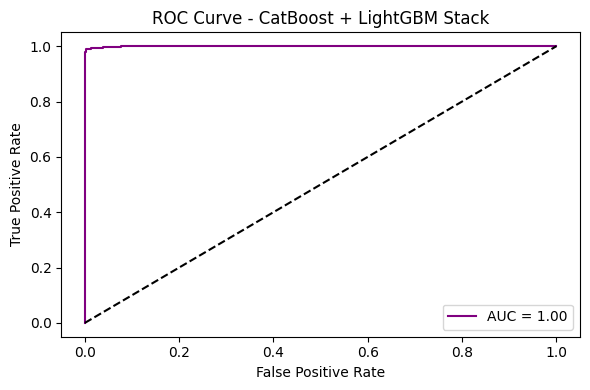

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
from catboost import CatBoostClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the Data
X = df_cleaned.drop(columns=['FLAG', 'Address'])  # Exclude 'Address' column
y = df_cleaned['FLAG']

# Select Numeric Features for Scaling
# Get a list of numeric features
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
# Use only numeric features for scaling
X_numeric = X[numeric_features]

# Scale the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Create Stacking Classifier
stack_model = StackingClassifier(
    estimators=[
        ('catboost', cat_model),
        ('lightgbm', lgb_model)
    ],
    final_estimator=lgb.LGBMClassifier(random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# Train the Stacking Model
stack_model.fit(X_train, y_train)

# Make Predictions
y_pred = stack_model.predict(X_test)
y_proba = stack_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print("\n=== Stacked Model Evaluation (All Features) ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"AUC-ROC:   {auc:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Stacked Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='purple')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost + LightGBM Stack")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

The stacked ensemble model demonstrates near-perfect classification performance with 99.44% accuracy and an AUC of 0.9995, effectively balancing fraud detection sensitivity (97.41% recall) with precision (100%), ensuring minimal false alerts.

This performance is particularly critical for on-chain analytics where mislabeling wallets can impact investor trust and signal quality. The model’s robustness makes it a powerful fraud-detection layer within a blockchain intelligence framework like Glassnode.